In [276]:
import torch
import torch.nn as nn
import torch.onnx
import onnx
import onnxruntime as ort
from onnx_tf.backend import prepare
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [277]:
x = np.linspace(0, 2 * np.pi, 1000, dtype=np.float32)
y = np.sin(x)

x_train = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y_train = torch.tensor(y, dtype=torch.float32).view(-1, 1)

model = nn.Sequential(
    nn.Linear(1, 50),
    nn.ReLU(),
    nn.Linear(50, 1)
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [278]:
for epoch in range(1000):
    optimizer.zero_grad()
    output = model(x_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

In [279]:
with torch.no_grad():
    y_pred = model(x_train).numpy()

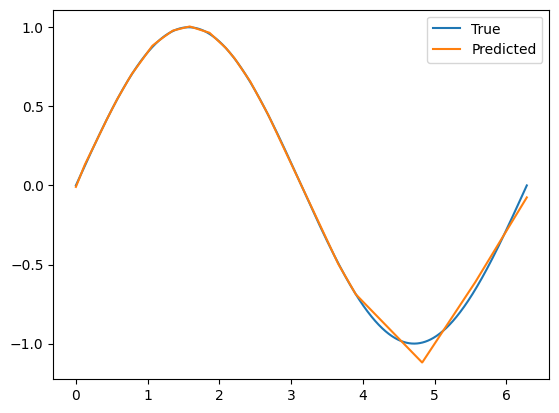

In [280]:
def plot_pred(x, y, y_pred):
    plt.plot(x, y, label='True')
    plt.plot(x, y_pred, label='Predicted')
    plt.legend()
    plt.show()

plot_pred(x, y, y_pred)

## Convert model to ONNX

In [281]:
data_size = (1, 1)
batch_size = 1
channels = 1

def convert_torch_to_onnx(model, onnx_model_path = 'model.onnx'):
    sample_input = torch.rand((batch_size, channels, *data_size))
    torch.onnx.export(
        model,
        sample_input, 
        onnx_model_path,
        verbose=False,
        input_names=['input'],
        output_names=['output'],
        opset_version=12
    )

onnx_model_path = 'model.onnx'
convert_torch_to_onnx(model, onnx_model_path)

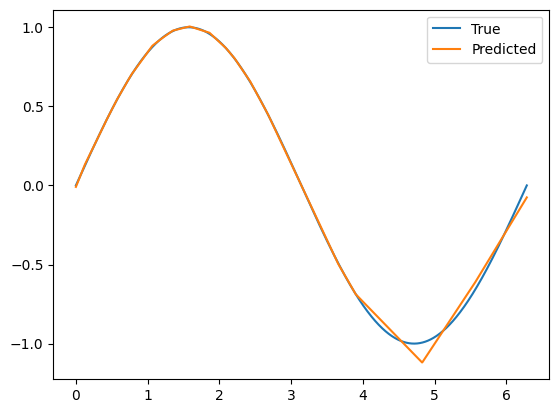

In [282]:
def test_onnx(onnx_model_path = 'model.onnx'):
    ort_session = ort.InferenceSession(onnx_model_path)

    onnx_y_pred = np.zeros(y.shape)
    for idx, _x in enumerate(x):
        x_train_np_reshaped = np.array([[[[_x]]]])

        ort_value = ort.OrtValue.ortvalue_from_numpy(x_train_np_reshaped)

        input_name = ort_session.get_inputs()[0].name
        inputs = {input_name: ort_value.numpy()}
        outputs = ort_session.run(None, inputs)[0][0][0][0][0]
        onnx_y_pred[idx] = outputs

    plot_pred(x, y, onnx_y_pred)
    
test_onnx(onnx_model_path)

## Convert model to tensorflow

In [283]:
def convert_onnx_to_tensorflow(onnx_model_path = 'model.onnx', tf_model_path = 'model_tf'):
    onnx_model = onnx.load(onnx_model_path)
    tf_rep = prepare(onnx_model)
    tf_rep.export_graph(tf_model_path)

tf_model_path = 'model_tf'
convert_onnx_to_tensorflow(onnx_model_path, tf_model_path)

INFO:tensorflow:Assets written to: model_tf\assets


INFO:tensorflow:Assets written to: model_tf\assets


## Convert model to tensorflow lite

In [287]:
def convert_tensorflow_to_tensorflow_lite(tf_model_path = 'model_tf', tflite_model_path = 'model.tflite'):
    def representative_dataset_gen():
        for i in range(1000):  # Generate 100 samples
            yield [np.array([x[i]], dtype=np.float32)] 
    converter = tf.lite.TFLiteConverter.from_saved_model(tf_model_path)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_dataset_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8
    tflite_model = converter.convert()

    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_model)

tflite_model_path = 'model.tflite'
convert_tensorflow_to_tensorflow_lite(tf_model_path, tflite_model_path)

ValueError: Cannot set tensor: Got value of type INT8 but expected type FLOAT32 for input 0, name: serving_default_input:0 

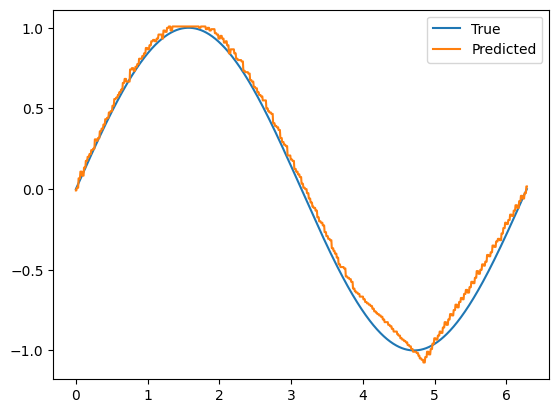

In [285]:
def test_tf_lite_model(tflite_model_path = 'model.tflite'):
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    tf_lite_y_pred = np.zeros(y.shape)
    for idx, _x in enumerate(x):
        input_data = np.array([[[[_x]]]])

        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])[0][0][0][0]
        tf_lite_y_pred[idx] = output_data

    plot_pred(x, y, tf_lite_y_pred)

test_tf_lite_model()

## Convert tensorflow lite to c++ file

In [286]:
def save_tflite_model_as_c_header(tflite_model_path = 'model.tflite', output_file_path = "./src/model.h"):
    with open(tflite_model_path, "rb") as f:
        tflite_model_content = f.read()

    header_content = "alignas(16) const unsigned char g_model[] = {"
    for i, byte in enumerate(tflite_model_content):
        if i % 12 == 0:
            header_content += "\n  "
        header_content += f"0x{byte:02x}, "
    header_content = header_content.rstrip(", ")
    header_content += "\n};"

    with open(output_file_path, "w") as f:
        f.write(header_content)

save_tflite_model_as_c_header()